# Setup

In [136]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [137]:
%matplotlib inline

In [138]:
import warnings
from matplotlib import rc
rc('text', usetex=True)
warnings.filterwarnings('ignore')

In [139]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy

import warnings

# Load data

In [117]:
from relaxed.analysis import setup, get_am

In [118]:
# catalog
hcat, indices, scales = setup('m11', path='../temp')

In [119]:
# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../temp')

# Histogram of NaNs

## m11

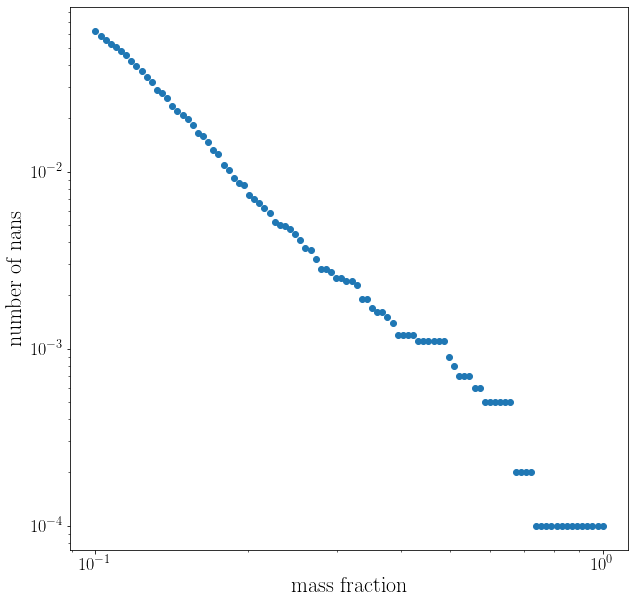

In [120]:
plt.figure(figsize=(10,10))
count_nans = np.array([ (sum(np.isnan(am[:, i]))+1)/(9999-sum(np.isnan(am[:,i]))) for i in range(len(mass_bins))])
plt.scatter(mass_bins, count_nans)
plt.xlabel('\\rm mass fraction', size=22)
plt.ylabel('\\rm number of nans', size=22)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.show()

## m12

In [65]:
hcat_12, indices, scales = setup('m12', path='../temp')
am_12, mass_bins_12 = get_am('m12', min_mass=0.1, path='../temp')

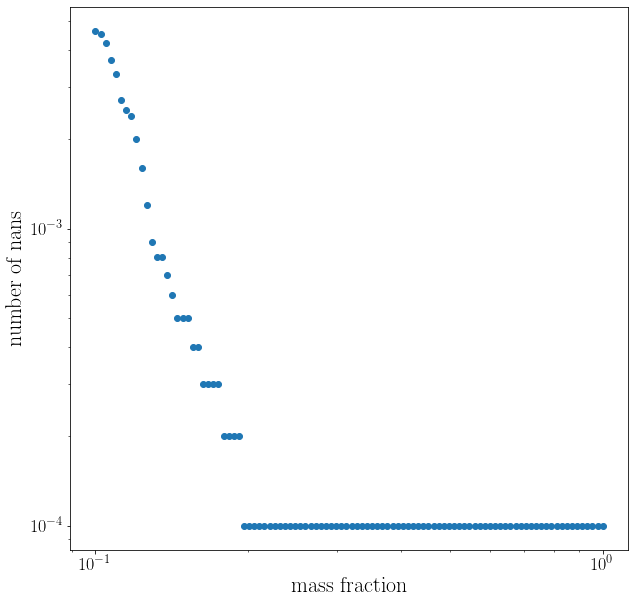

In [66]:
plt.figure(figsize=(10,10))
count_nans = np.array([ (sum(np.isnan(am_12[:, i]))+1)/(9999-sum(np.isnan(am_12[:,i]))) for i in range(len(mass_bins_12))])
plt.scatter(mass_bins_12, count_nans)
plt.xlabel('\\rm mass fraction', size=22)
plt.ylabel('\\rm number of nans', size=22)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.show()

# Algorithm

In [91]:
from scipy import stats
from scipy.stats import spearmanr


def get_quantiles(arr):
    return np.vectorize(lambda x: stats.percentileofscore(arr, x))(arr) / 100.

1. We start by obtaining the rank of both $c_{\rm vir}$ and $a(m)$ for each $m$.

In [95]:
cvir = hcat.cat['cvir']
r_cvir = get_quantiles(cvir)

r_am = [] 
for i in range(am.shape[1]):
    am_i = am[:, i]
    r_am_i = get_quantiles(am_i)
    r_am.append(r_am_i)
r_am = np.array(r_am).T

2. Look at some of the marginal distributions of $\log c_{\rm vir}$ and $\log a(m)$ for some values of $m$ to try to transform them to Gaussians.

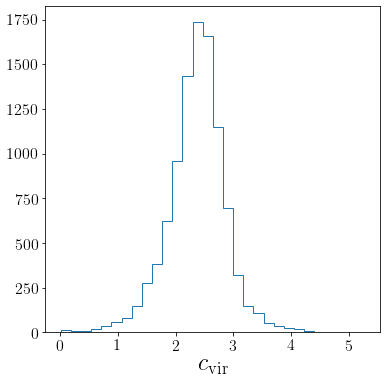

In [128]:
plt.figure(figsize=(6,6))
plt.hist(np.log(cvir), bins=30, histtype='step');
plt.xlabel("$c_{\\rm vir}$", size=24)
plt.tick_params(which='both', labelsize=16)

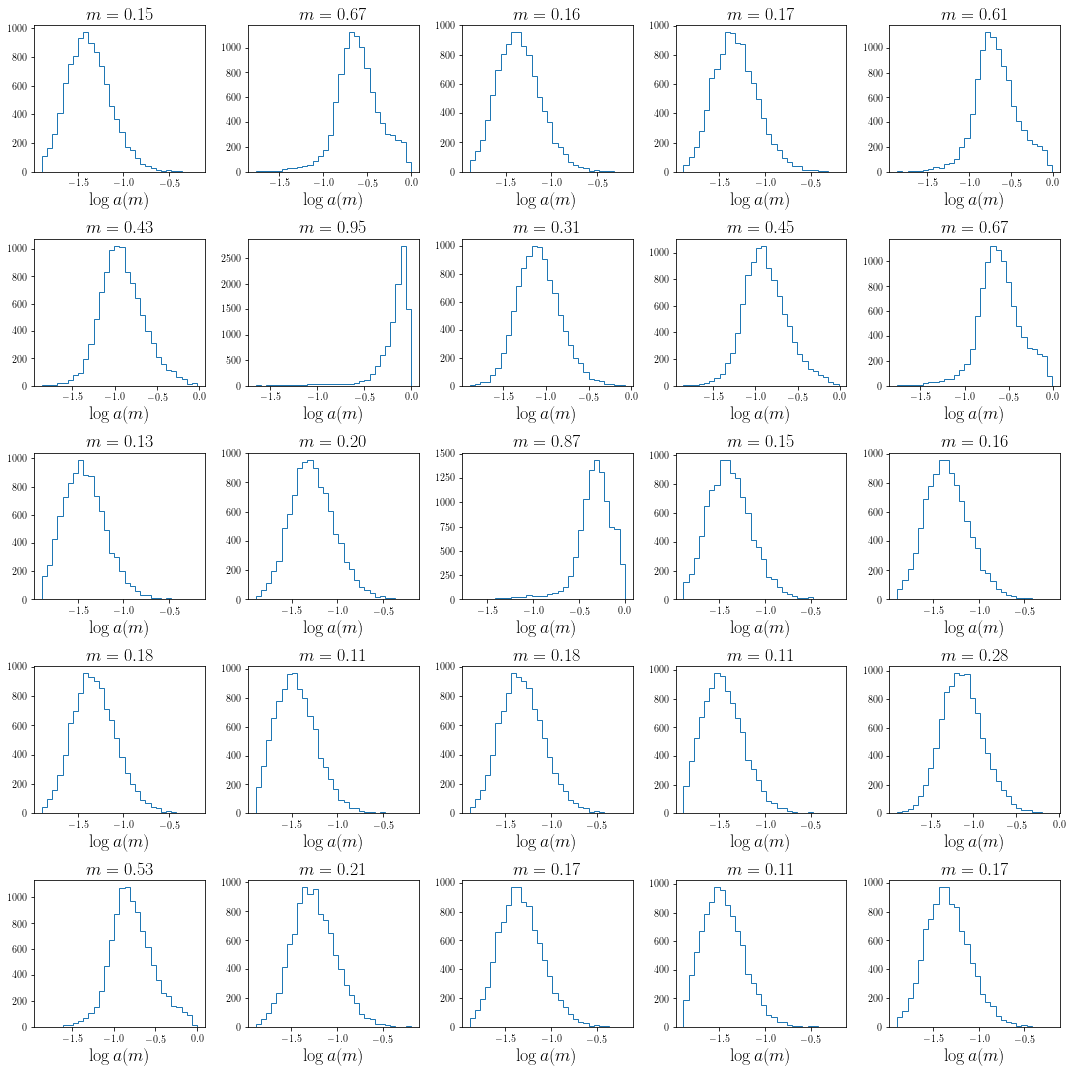

In [146]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(25): 
    ax = axes[i]
    j = np.random.randint(am.shape[1])
    mass_bin = mass_bins[j]
    ax.hist(np.log(am[:, j]), histtype='step', bins=30)
    ax.set_title(f"$m={mass_bin:.2f}$", size=18)
    ax.set_xlabel("$\\log a(m)$", size=18)
plt.tight_layout()

In [107]:
# (2) calculate correlations between r_am and r_cvir:
corrs = [] # one for each am.shape[1] (mass bin)
for i in range(am.shape[1]):
    corrs.append(spearmanr(cvir, am[:, i], nan_policy='omit')[0])
corrs = np.array(corrs)

In [16]:
am.shape

(9999, 100)

In [18]:
sum(np.isnan(am[:, 40]))

40

In [ ]:
# (1) convert cvir and a_m to rank quantities.